In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import calendar
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import scipy.stats as stats
from geopy.geocoders import Nominatim
import time


# Data analysis

## _This notebook is dedicated to the dataset analysis. After having cleaned the data earlier, we will now add additional columns or optimize the current data to be able to extract all the useful information from the dataset, using additional data visualization tools. Right after that, we will dive deeper in the correlations between variables to fully understand how to turn this data into business insights and actions._

# Feature engineering

In [3]:
df = pd.read_csv("../data/rides_data_clean.csv")
print(df.head(5))

   Unnamed: 0  month  day  weekday  hour    booking_id   booking_status  \
0           0      3   23        5    12  "CNR5884300"  No Driver Found   
1           1     11   29        4    18  "CNR1326809"       Incomplete   
2           2      8   23        4     8  "CNR8494506"        Completed   
3           3     10   21        0    17  "CNR8906825"        Completed   
4           4      9   16        0    22  "CNR1950162"        Completed   

    customer_id   vehicle_type      pickup_location      drop_location  \
0  "CID1982111"          eBike          Palam Vihar            Jhilmil   
1  "CID4604802"       Go Sedan        Shastri Nagar  Gurgaon Sector 56   
2  "CID9202816"           Auto              Khandsa      Malviya Nagar   
3  "CID2610914"  Premier Sedan  Central Secretariat           Inderlok   
4  "CID9933542"           Bike     Ghitorni Village        Khan Market   

   avg_vtat reason_for_cancelling_by_customer driver_cancellation_reason  \
0       0.0                 

In [4]:
# Import the geocoded locations
geo_df = pd.read_csv("../data/geocoded_locations.csv", index_col="location")
print(geo_df.head(10))

                   latitude  longitude
location                              
AIIMS             28.566860  77.207806
Adarsh Nagar      28.716580  77.170422
Akshardham        28.612517  77.277318
Ambience Mall     28.541245  77.155108
Anand Vihar       28.646834  77.315875
Anand Vihar ISBT  28.649052  77.318284
Ardee City        28.441041  77.079208
Arjangarh         28.478729  77.120951
Ashok Park Main   28.671605  77.155291
Ashok Vihar       19.116503  72.886755


In [5]:
# We add the GPS location to the dataset 

df["pickup_latitude"] = df["pickup_location"].map(geo_df["latitude"])
df["pickup_longitude"] = df["pickup_location"].map(geo_df["longitude"])

df["drop_latitude"] = df["drop_location"].map(geo_df["latitude"])
df["drop_longitude"] = df["drop_location"].map(geo_df["longitude"])

print(df.head(5))

print(df.count())


   Unnamed: 0  month  day  weekday  hour    booking_id   booking_status  \
0           0      3   23        5    12  "CNR5884300"  No Driver Found   
1           1     11   29        4    18  "CNR1326809"       Incomplete   
2           2      8   23        4     8  "CNR8494506"        Completed   
3           3     10   21        0    17  "CNR8906825"        Completed   
4           4      9   16        0    22  "CNR1950162"        Completed   

    customer_id   vehicle_type      pickup_location  ...  \
0  "CID1982111"          eBike          Palam Vihar  ...   
1  "CID4604802"       Go Sedan        Shastri Nagar  ...   
2  "CID9202816"           Auto              Khandsa  ...   
3  "CID2610914"  Premier Sedan  Central Secretariat  ...   
4  "CID9933542"           Bike     Ghitorni Village  ...   

  incomplete_rides_reason  booking_value ride_distance driver_rating  \
0                     NaN            0.0          0.00          -1.0   
1       Vehicle Breakdown          237.0    

In [6]:
# Let's replace the weekdays numbers by the weekday names

weekday_name = {
    0: "Monday",
    1: "Tuesday",
    2: "Wednesday",
    3: "Thursday",
    4: "Friday",
    5: "Saturday",
    6: "Sunday"
}

df["weekday"] = df["weekday"].map(weekday_name)

print(df["weekday"].head())

0    Saturday
1      Friday
2      Friday
3      Monday
4      Monday
Name: weekday, dtype: object


In [7]:
# We convert booking value in USD based on the current exchange rate in September 2025 (1 INR = 0.011 USD)

df["booking_value"] = df["booking_value"] * 0.011
df["booking_value"] = df["booking_value"].round(2)

print(df["booking_value"].head(5))

0    0.00
1    2.61
2    6.90
3    4.58
4    8.11
Name: booking_value, dtype: float64


# Additional data visualization

In [9]:
# Observation of the number of rides per day per vehicle type

order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
df_grouped = df.groupby(["weekday", "vehicle_type"]).size()
df_grouped = df.groupby(["weekday", "vehicle_type"]).size().reset_index(name="rides")
df_grouped["weekday"] = pd.Categorical(df_grouped["weekday"], categories = order, ordered=True)
df_grouped = df_grouped.sort_values("weekday")
print(df_grouped.head(15))


      weekday   vehicle_type  rides
13     Monday          eBike   1508
7      Monday           Auto   5388
8      Monday           Bike   3260
9      Monday        Go Mini   4285
10     Monday       Go Sedan   3940
11     Monday  Premier Sedan   2638
12     Monday        Uber XL    625
35    Tuesday           Auto   5318
36    Tuesday           Bike   3224
37    Tuesday        Go Mini   4257
38    Tuesday       Go Sedan   3894
41    Tuesday          eBike   1468
39    Tuesday  Premier Sedan   2587
40    Tuesday        Uber XL    643
47  Wednesday        Uber XL    650


In [10]:
fig = px.line(df_grouped, x="weekday", y="rides", color="vehicle_type")
fig.update_layout(title = 'Rides per weekday and vehicle types', xaxis_title = 'Weekday', yaxis_title = 'Rides', legend_title = "Vehicle type")
fig.show()

print("\n\n We can observe a steady number of rides accross the week for every kind of vehicle type")



 We can observe a steady number of rides accross the week for every kind of vehicle type


In [11]:
# Observation of the number of rides per hour per vehicle type

df_grouped_h = df.groupby(["hour", "vehicle_type"]).size()
df_grouped_h = df.groupby(["hour", "vehicle_type"]).size().reset_index(name = "rides")
df_grouped_h = df_grouped_h.sort_values("hour")


In [12]:
fig = px.line(df_grouped_h, x = "hour", y = "rides", color = "vehicle_type")
fig.update_layout(title = "Rides per hour per vehicle type", xaxis_title = "Hour", yaxis_title = "Rides", legend_title = "Vehicle type")
fig.show()

print("\n\n The rides number variations follow the same pattern for every vehicle types, although the auto rides have more pronounced variations. \
The two activity peaks during the day are 10am and 6pm")




 The rides number variations follow the same pattern for every vehicle types, although the auto rides have more pronounced variations. The two activity peaks during the day are 10am and 6pm


In [13]:
# Let's have a look at the most usual places for pick up a Uber in India based on the data

pickup_hotspots = (
    df.groupby(["pickup_location","pickup_latitude","pickup_longitude"], as_index=False)
      .size()
      .rename(columns={"size":"rides"})
)

fig = px.scatter_mapbox(
    pickup_hotspots,
    lat="pickup_latitude", lon="pickup_longitude",
    size="rides", size_max=15,
    color="rides", color_continuous_scale="Turbo",
    hover_name="pickup_location",
    hover_data={"rides": True, "pickup_latitude": False, "pickup_longitude": False},
    mapbox_style="open-street-map",
    zoom=5, center={"lat": 28.6, "lon": 77.2},
    title="Pickup hotspots"
)
fig.update_layout(margin=dict(l=0,r=0,t=30,b=0))
fig.show()



In [14]:
# Let's have a look at the most popular drop places now

drop_hotspots = (
    df.groupby(["drop_location","drop_latitude","drop_longitude"], as_index=False)
      .size()
      .rename(columns={"size":"rides"})
)

fig = px.scatter_mapbox(
    drop_hotspots,
    lat="drop_latitude", lon="drop_longitude",
    size="rides", size_max=20,
    color="rides", color_continuous_scale="Rainbow",
    hover_name="drop_location",
    hover_data={"rides": True, "drop_latitude": False, "drop_longitude": False},
    mapbox_style="open-street-map",
    zoom=5, center={"lat": 28.6, "lon": 77.2},
    title="Drop hotspots"
)
fig.update_layout(margin=dict(l=0,r=0,t=30,b=0))
fig.show()

In [15]:
# Let's have a look on the data outside Delhi to see if it may be relevant to analyze it

df.loc[:, "in_delhi"] = (
    df["pickup_latitude"].between(28.4, 28.9) &
    df["pickup_longitude"].between(76.8, 77.4)
)

mean_value = df["in_delhi"].mean()

print(df["in_delhi"].value_counts())
print("\nThe total rides share done in Delhi is", np.round((mean_value*100),2),"%")


in_delhi
True     114382
False     35618
Name: count, dtype: int64

The total rides share done in Delhi is 76.25 %


In [16]:
# It seems that the main data is related to New Delhi area, we will then focus on this urban area 
# with geocoded pickup and drop locationsand drop the other data 
# to get a more relevant data analysis since New Delhi activity may differ
# from the rest of the country and we don't have enough data to compare Uber rides between various Indian cities

df = df[df["in_delhi"] == True]
df = df.dropna(subset=["drop_latitude", "drop_longitude"])

print(df.count())

Unnamed: 0                           113090
month                                113090
day                                  113090
weekday                              113090
hour                                 113090
booking_id                           113090
booking_status                       113090
customer_id                          113090
vehicle_type                         113090
pickup_location                      113090
drop_location                        113090
avg_vtat                             113090
reason_for_cancelling_by_customer      7918
driver_cancellation_reason            20289
incomplete_rides_reason                6787
booking_value                        113090
ride_distance                        113090
driver_rating                        113090
customer_rating                      113090
payment_method                       113090
pickup_latitude                      113090
pickup_longitude                     113090
drop_latitude                   

# Statistical tests

## Let's assess the potential correlations between variables

In [18]:
# Let's drop the in_delhi column, not relevant on the already filtered dataset
df.drop("in_delhi", axis=1, inplace=True)


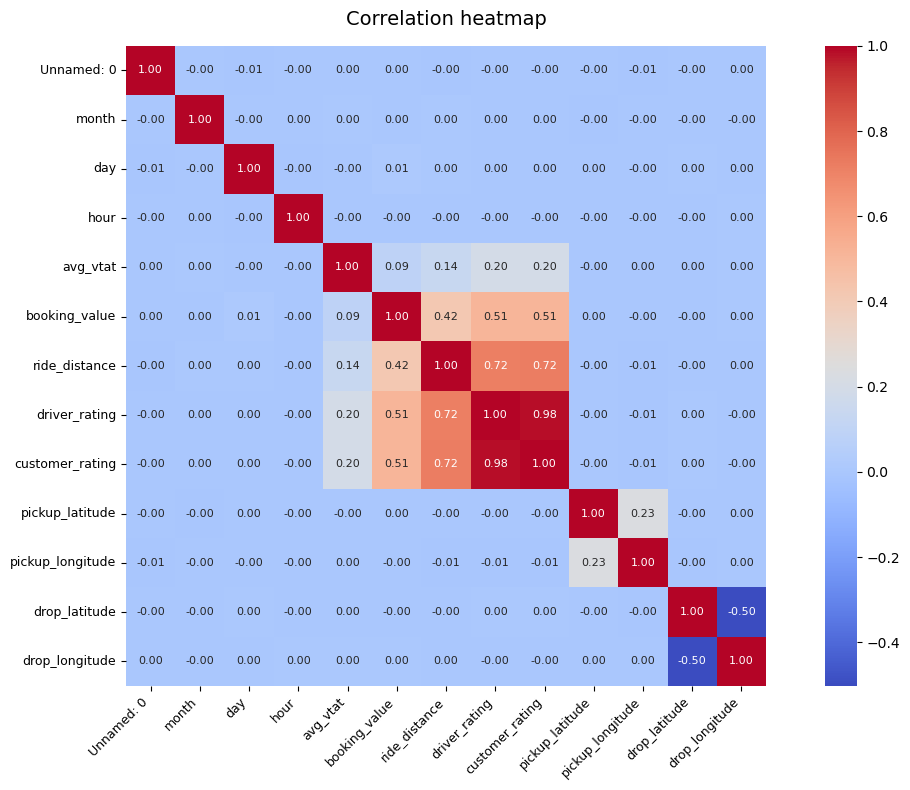


The heatmap confirms that ride distance is the main driver of booking value, while other factors such as payment method, 
vehicle type, day, or hour show little correlation. Driver and customer ratings are highly consistent, 
making them essentially redundant as performance indicators. Waiting time (avg_vtat) has only a very weak link to ratings, 
and geographic pickup/drop coordinates have no meaningful effect on either pricing or satisfaction.
Let's dive deeper into the correlations between variables with more robust statistical tests


In [19]:
plt.figure(figsize=(12, 8))  # agrandir le graphique

sns.heatmap(
    df.corr(numeric_only=True),
    annot=True,        
    fmt=".2f",         
    cmap="coolwarm",   
    cbar=True,         
    square=True,       
    annot_kws={"size":8}  
)

plt.title("Correlation heatmap", fontsize=14, pad=15)
plt.xticks(rotation=45, ha="right", fontsize=9)  # rotation des labels
plt.yticks(fontsize=9)
plt.tight_layout()
plt.show()

print("""\nThe heatmap confirms that ride distance is the main driver of booking value, while other factors such as payment method, 
vehicle type, day, or hour show little correlation. Driver and customer ratings are highly consistent, 
making them essentially redundant as performance indicators. Waiting time (avg_vtat) has only a very weak link to ratings, 
and geographic pickup/drop coordinates have no meaningful effect on either pricing or satisfaction.
Let's dive deeper into the correlations between variables with more robust statistical tests""")



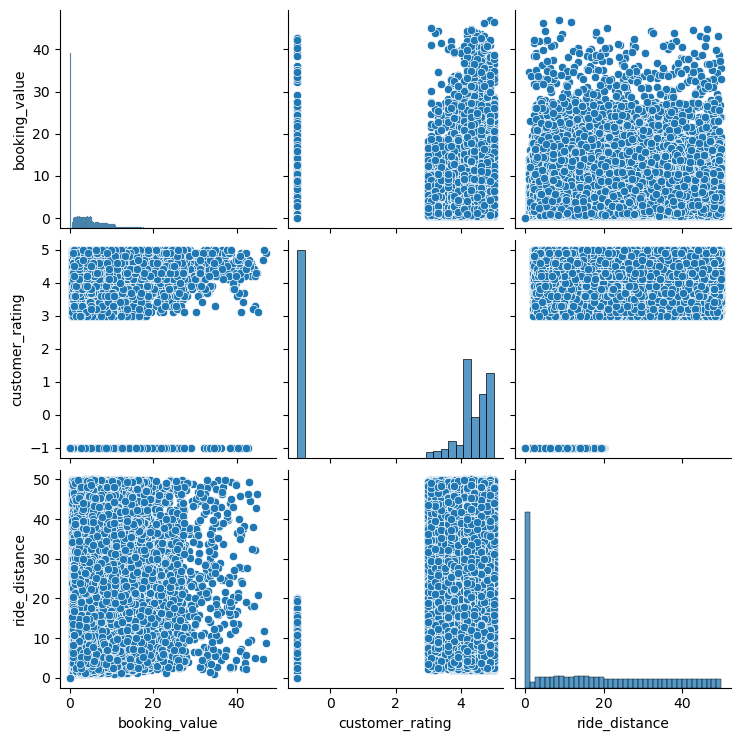


The pairplot confirms that ride distance is the main driver of booking value, as longer trips consistently lead to higher fares. 
However, customer ratings remain stable and high, showing little to no relationship with either distance or booking value. 
This suggests that pricing and trip length do not significantly influence customer satisfaction, which is consistently positive. 
Finally, both booking value and ride distance exhibit a long-tail distribution, with most trips being short and inexpensive, 
while a few long trips account for higher fares.


In [20]:
sns.pairplot(data=df, vars=["booking_value", "customer_rating", "ride_distance"])
plt.show()

print("""\nThe pairplot confirms that ride distance is the main driver of booking value, as longer trips consistently lead to higher fares. 
However, customer ratings remain stable and high, showing little to no relationship with either distance or booking value. 
This suggests that pricing and trip length do not significantly influence customer satisfaction, which is consistently positive. 
Finally, both booking value and ride distance exhibit a long-tail distribution, with most trips being short and inexpensive, 
while a few long trips account for higher fares.""")

The ANOVA statistical test result between booking value and payment method is :

                      df        sum_sq    mean_sq         F    PR(>F)
payment_method      4.0  5.029220e+01  12.573051  0.665327  0.616004
Residual        76918.0  1.453562e+06  18.897559       NaN       NaN 



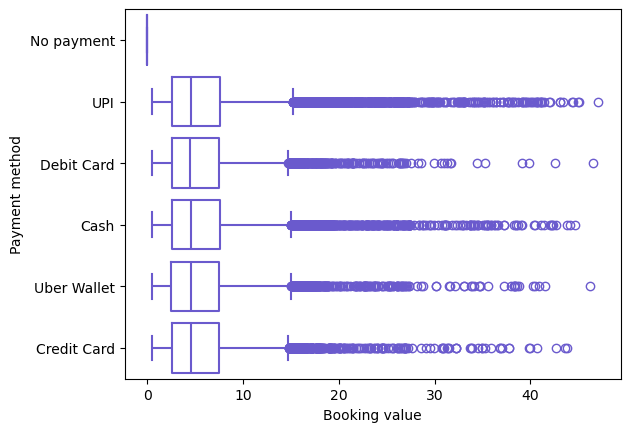



The analysis shows no significant difference in booking values across payment methods. 
This means that how customers choose to pay does not materially impact ride prices. 
The high number of outliers reflects normal variations driven by trip distance, demand surges, and peak hours rather than payment behavior.



In [21]:
# We want to test if the payment method has an influence on the booking_value

# H0 : the payment method has no significative influence on the booking value
# H1 the payment method influences the booking value

import statsmodels.api as sm
import statsmodels.formula.api as smf

df_with_payments = df[df["payment_method"] != "No payment"]

result = smf.ols('booking_value ~ payment_method', data = df_with_payments).fit()

print("The ANOVA statistical test result between booking value and payment method is :\n\n", sm.stats.anova_lm(result), "\n")

sns.boxplot(data=df, x="booking_value", y="payment_method", legend="auto", color="slateblue", fill = False)
plt.xlabel("Booking value")
plt.ylabel("Payment method")
plt.show()

print("""\n\nThe analysis shows no significant difference in booking values across payment methods. 
This means that how customers choose to pay does not materially impact ride prices. 
The high number of outliers reflects normal variations driven by trip distance, demand surges, and peak hours rather than payment behavior.\n""")

The ANOVA statistical test result between booking value and vehicle type is :

                     df        sum_sq    mean_sq         F    PR(>F)
vehicle_type       6.0  3.941607e+01   6.569345  0.334148  0.919247
Residual      113083.0  2.223209e+06  19.659978       NaN       NaN 



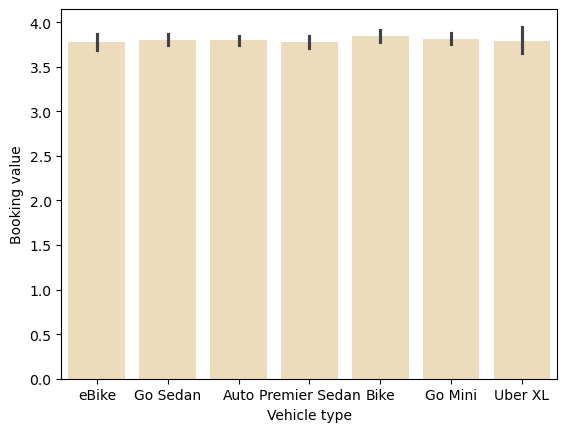



Booking values remain consistent across all vehicle types, with no significant differences detected. 
This indicates that the choice of vehicle does not materially influence ride prices.
Variations in booking value are therefore more likely explained by other factors such as trip distance, demand surges, or time of day. 



In [22]:
# We want to test if the vehicle type has an influence on the booking_value, let's do another ANOVA test

# H0 : the vehicle type has no significative influence on the booking value
# H1 the vehicle type influences the booking value

result = smf.ols('booking_value ~ vehicle_type', data = df ).fit()

print("The ANOVA statistical test result between booking value and vehicle type is :\n\n", sm.stats.anova_lm(result),"\n")

sns.barplot(data=df, x="vehicle_type", y="booking_value", legend="auto", color="wheat")
plt.xlabel("Vehicle type")
plt.ylabel("Booking value")
plt.show()

print("""\n\nBooking values remain consistent across all vehicle types, with no significant differences detected. 
This indicates that the choice of vehicle does not materially influence ride prices.
Variations in booking value are therefore more likely explained by other factors such as trip distance, demand surges, or time of day. \n""")

Spearman statistical test results (month and booking values) : SignificanceResult(statistic=-0.00012981082065976788, pvalue=0.9651806752489092) 

Spearman statistical test results (weekday and booking value) : SignificanceResult(statistic=-0.013498384539463495, pvalue=5.638537210666793e-06) 



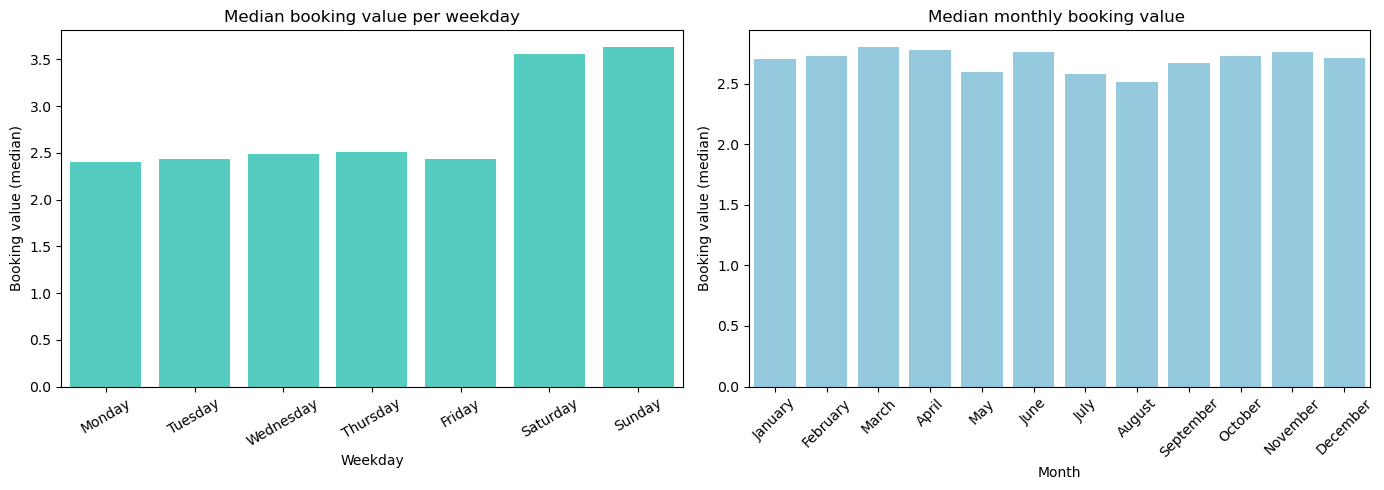



Even though the charts indicate that weekend rides are slightly more expensive on average than weekday rides, 
the statistical analysis shows that this difference is not strong enough to be considered significant. 
In practice, this means that pricing does not consistently depend on the day of the week, and other factors
(such as trip distance, demand surges, or customer location) are likely to have a much stronger impact on booking value than the weekday itself.


In [23]:
# Let's check if the month and weekdays have an influence on the booking_value thanks to two Spearman tests

# H0 : the month/weekday has no significative influence on the booking value
# H1 the month/weekday influences the booking value

from scipy.stats import spearmanr
spear_test_month = spearmanr(df["month"],df["booking_value"])
print("Spearman statistical test results (month and booking values) :",spear_test_month,"\n")

spear_test_weekday = spearmanr(df["weekday"],df["booking_value"])
print("Spearman statistical test results (weekday and booking value) :", spear_test_weekday,"\n")


day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
df["weekday"] = pd.Categorical(df["weekday"], categories=day_order, ordered=True)

month_order = list(calendar.month_name[1:])  # ['January', ..., 'December']
df["month"] = df["month"].map(lambda x: calendar.month_name[int(x)])  # 1 -> January
df["month"] = pd.Categorical(df["month"], categories=month_order, ordered=True)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))  
sns.barplot(
    data=df,
    x="weekday", y="booking_value",
    estimator=np.median, errorbar=None,
    ax=axes[0], color="Turquoise")
axes[0].set_title("Median booking value per weekday")
axes[0].set_xlabel("Weekday")
axes[0].set_ylabel("Booking value (median)")
axes[0].tick_params(axis='x', rotation=30)  

sns.barplot(
    data=df,
    x="month", y="booking_value",
    estimator=np.median, errorbar=None,
    ax=axes[1], color="Skyblue")
axes[1].set_title("Median monthly booking value ")
axes[1].set_xlabel("Month")
axes[1].set_ylabel("Booking value (median)")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("""\n\nEven though the charts indicate that weekend rides are slightly more expensive on average than weekday rides, 
the statistical analysis shows that this difference is not strong enough to be considered significant. 
In practice, this means that pricing does not consistently depend on the day of the week, and other factors
(such as trip distance, demand surges, or customer location) are likely to have a much stronger impact on booking value than the weekday itself.""")


In [24]:
# Let's check if the average time to arrive at trip influences the customer rating using a Spearman test

# H0 : the average time to arrive at trip has no significative influence on the customer rating
# H1 the average time to arrive at trip has statistically significant influence on the customer rating

df_filtered = df[df["customer_rating"].between(0,5)]

spear_test_avg_vtat = spearmanr(df_filtered["avg_vtat"], df_filtered["customer_rating"])
print("Spearman statistical test results (avg VTAT and customer rating) :", spear_test_avg_vtat, "\n")


print("""The statistical test shows no significant relationship between the average time to arrive at the trip and the customer rating 
(p-value = 0.66). This means that, based on the available data, variations in arrival time do not have a measurable impact on 
how customers rate their rides. In practice, improving customer ratings will likely depend more on other factors such as driver behavior, 
trip experience, or pricing rather than small changes in arrival time.""")



Spearman statistical test results (avg VTAT and customer rating) : SignificanceResult(statistic=-0.0016509579328211565, pvalue=0.6619525075757687) 

The statistical test shows no significant relationship between the average time to arrive at the trip and the customer rating 
(p-value = 0.66). This means that, based on the available data, variations in arrival time do not have a measurable impact on 
how customers rate their rides. In practice, improving customer ratings will likely depend more on other factors such as driver behavior, 
trip experience, or pricing rather than small changes in arrival time.


ANOVA statistical test results (between vehicle type and customer rating) :
                     df         sum_sq   mean_sq        F    PR(>F)
vehicle_type       6.0      28.759122  4.793187  0.68465  0.662077
Residual      113083.0  791685.838513  7.000927      NaN       NaN 




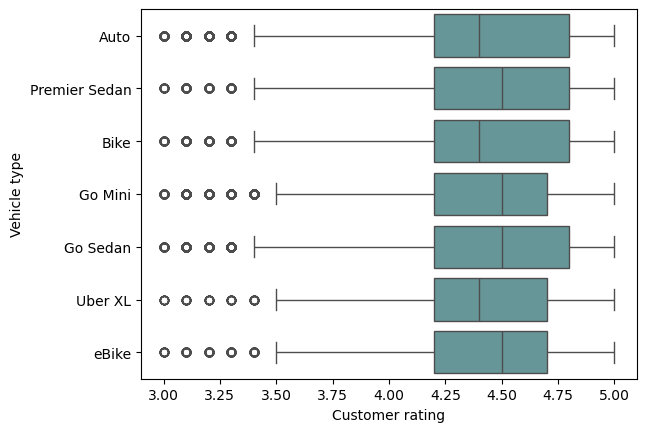



Customer satisfaction scores remain consistently high across all vehicle types. 
This suggests that factors other than vehicle type (e.g., driver behavior, pricing, or trip experience) 
play a more important role in influencing customer ratings. 
Therefore, focusing only on upgrading or changing vehicle categories is unlikely to deliver measurable improvements in ratings.


In [25]:
# We want to test if the vehicle type has an influence on the customer rating, let's do an ANOVA test

# H0 : the vehicle type has no significative influence on the customer rating
# H1 the vehicle type influences the customer rating

result = smf.ols('customer_rating ~ vehicle_type', data = df ).fit()

print("ANOVA statistical test results (between vehicle type and customer rating) :\n", sm.stats.anova_lm(result),"\n\n")

sns.boxplot(data=df_filtered, x="customer_rating", y="vehicle_type", legend="auto", color="cadetblue")
plt.xlabel("Customer rating")
plt.ylabel("Vehicle type")
plt.show()

print("""\n\nCustomer satisfaction scores remain consistently high across all vehicle types. 
This suggests that factors other than vehicle type (e.g., driver behavior, pricing, or trip experience) 
play a more important role in influencing customer ratings. 
Therefore, focusing only on upgrading or changing vehicle categories is unlikely to deliver measurable improvements in ratings.""")


ANOVA statistical test results (avg VTAT and customer rating) :

                          df        sum_sq        mean_sq             F  PR(>F)
C(booking_status)       4.0  7.172333e+05  179308.317111  15534.905687     0.0
Residual           113085.0  1.305259e+06      11.542286           NaN     NaN 




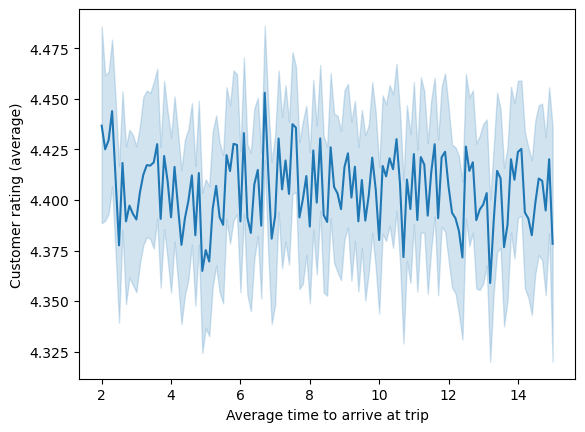


Although the ANOVA test indicates a statistically significant relationship between arrival time and customer rating (p < 0.05), 
the effect size is extremely small. This means that, in practice, customer ratings remain stable regardless of arrival time. 
From a business perspective, optimizing arrival time is unlikely to drive meaningful improvements in customer satisfaction scores.


In [26]:
# We want to test if the average time to arrive at trip has an influence on the booking status, let's do an ANOVA test

# H0 : the average time to arrive at trip  has no significative influence on the booking status
# H1 the average time to arrive at trip influences the booking status

result = smf.ols('avg_vtat ~ C(booking_status)', data = df ).fit()

print("ANOVA statistical test results (avg VTAT and customer rating) :\n\n", sm.stats.anova_lm(result), "\n\n")

sns.lineplot(data=df_filtered, x = "avg_vtat", y = "customer_rating")
plt.xlabel("Average time to arrive at trip")
plt.ylabel("Customer rating (average)")
plt.show()

print("""\nAlthough the ANOVA test indicates a statistically significant relationship between arrival time and customer rating (p < 0.05), 
the effect size is extremely small. This means that, in practice, customer ratings remain stable regardless of arrival time. 
From a business perspective, optimizing arrival time is unlikely to drive meaningful improvements in customer satisfaction scores.""")

ANOVA statistical test results (pickup locations and avg VTAT) :

                           df        sum_sq    mean_sq         F    PR(>F)
C(pickup_location)     133.0  2.461081e+03  18.504372  1.034726  0.374293
Residual            112956.0  2.020032e+06  17.883349       NaN       NaN 




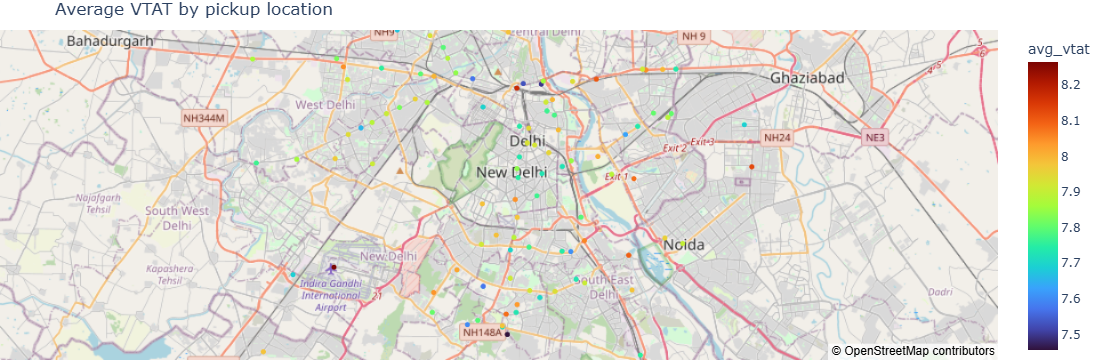

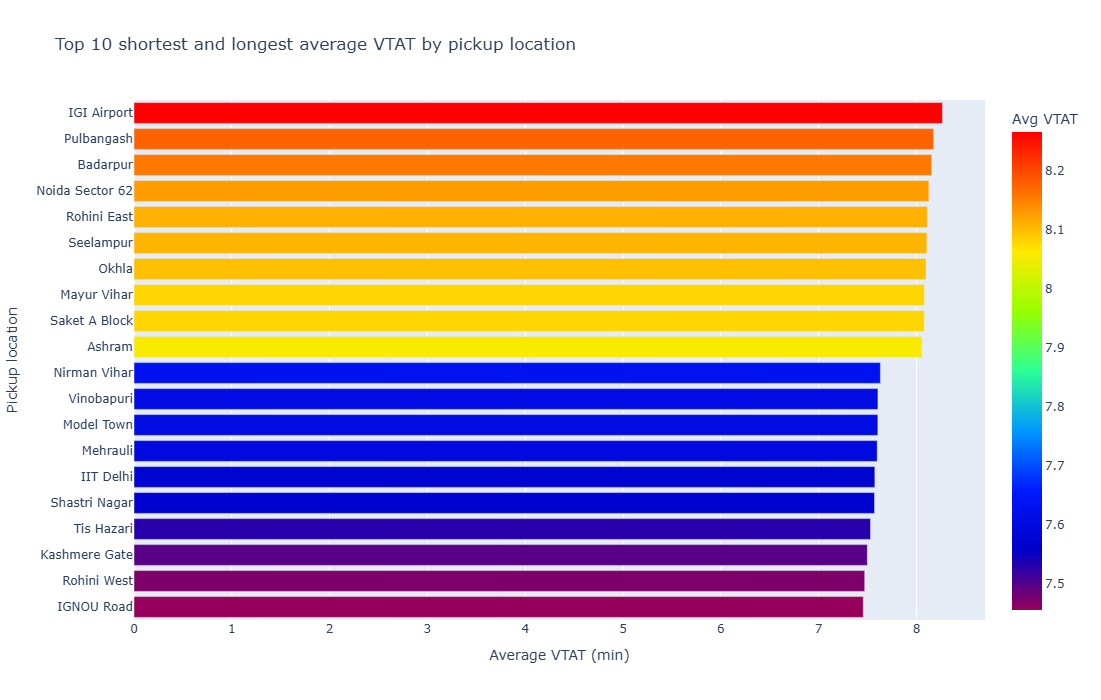


Average pickup times are consistent across all locations, with only minor differences (less than one minute) 
between the fastest and slowest areas. This confirms that pickup location does not significantly influence arrival times. 
Operational improvements should therefore focus on other factors (driver availability, demand surges, pricing) rather than geography.


In [27]:
# We want to test if the pickup location has an influence on the average time to arrive at trip, let's do an ANOVA test

# H0 : the pickup location has no significative influence on the average time to arrive at trip
# H1 the pickup location influences the average time to arrive at trip

result = smf.ols('avg_vtat ~ C(pickup_location)', data = df ).fit()

print("ANOVA statistical test results (pickup locations and avg VTAT) :\n\n", sm.stats.anova_lm(result), "\n\n")

pickup_vtat = (df.groupby(["pickup_location", "pickup_latitude", "pickup_longitude"], as_index=False).agg(avg_vtat=("avg_vtat", "mean")))

fig = px.scatter_mapbox(
    pickup_vtat,
    lat="pickup_latitude", lon="pickup_longitude",
    size_max=30,
    color="avg_vtat", color_continuous_scale="Turbo",
    hover_name="pickup_location",
    hover_data={"avg_vtat": True, "pickup_latitude": False, "pickup_longitude": False},
    mapbox_style="open-street-map",
    zoom=10, center={"lat": 28.6, "lon": 77.2},
    title="Average VTAT by pickup location")
fig.update_layout(margin=dict(l=0, r=0, t=30, b=0))
fig.show()

# Calculer la moyenne par pickup_location et trier
pickup_vtat = (
    df.groupby("pickup_location", as_index=False)["avg_vtat"].mean()
    .sort_values("avg_vtat", ascending=True)
)

# Garder les 10 plus courtes et les 10 plus longues
pickup_vtat_topbottom = pd.concat([pickup_vtat.head(10), pickup_vtat.tail(10)])

# Barplot
fig = px.bar(
    pickup_vtat_topbottom,
    x="avg_vtat", y="pickup_location",
    orientation="h",
    color="avg_vtat", color_continuous_scale="Rainbow",
    title="Top 10 shortest and longest average VTAT by pickup location"
)

fig.update_layout(
    xaxis_title="Average VTAT (min)",
    yaxis_title="Pickup location",
    coloraxis_colorbar_title="Avg VTAT",
    yaxis=dict(tickmode="linear"),
    height=700
)
fig.show()


print("""\nAverage pickup times are consistent across all locations, with only minor differences (less than one minute) 
between the fastest and slowest areas. This confirms that pickup location does not significantly influence arrival times. 
Operational improvements should therefore focus on other factors (driver availability, demand surges, pricing) rather than geography.""")

## Conclusion

This analysis shows that common operational and transactional factors — such as **payment method, vehicle type, pickup location, or average arrival time (VTAT)** — have **no statistically significant effect** on booking value or customer rating.

- **Booking values** appear primarily driven by **trip characteristics** (distance, surge pricing, time of day) rather than how customers pay or which vehicle they choose.  
- **Customer ratings** remain consistently high and are **not influenced** by VTAT or other operational features.  
- **Temporal patterns** (weekday, month) suggest only a slight weekend uplift, without strong seasonality.  

📊 **Business implications:**  
- Revenue growth should focus on **demand management and pricing strategies**, not on payment diversification or fleet mix.  
- Customer satisfaction should be enhanced through **experience-driven initiatives** (ease of booking, app usability, transparency), rather than operational tweaks.  

🔮 **Next steps:** incorporating external variables (traffic conditions, weather, local events) and replicating the analysis across multiple Indian cities would strengthen these findings and validate their generalizability.



In [29]:
df_clean = df_filtered.loc[:, ~df_filtered.columns.str.contains(r"^Unnamed", na=False)]
df_clean = df_clean.set_index("booking_id")
df_clean.to_csv("../data/rides_data_delhi_clean.csv")

